In [1]:
import pandas as pd

In [5]:
time_taken = pd.Series([1174.0,
573.0,
358.0,
983.0,
455.0,
242.0,
255.0,
389.0,
323.0,
465.0,
436.0,
1094.0,
283.0,
947.0,
291.0,
719.0,
364.0,
343.0,
185.0,
271.0,
685.0,
342.0,
1752.0,
215.0,
2324.0,
747.0,
571.0,
477.0,
654.0,
288.0,
419.0,
235.0,
347.0,
785.0,
678.0,
716.0,
474.0,
334.0,
891.0,
268.0,
271.0,
652.0,
344.0,
170.0,
249.0,
225.0,
349.0,
231.0,
376.0,
486.0,
875.0,
298.0,
269.0,
801.0,
295.0,
635.0,
370.0,
145.0,
698.0,
409.0,
678.0,
282.0,
305.0,
372.0,
465.0,
639.0,
202.0,
285.0,
627.0,
364.0,
792.0,
616.0,
398.0,
473.0,
647.0,
332.0,
1656.0,
202.0,
279.0,
835.0,
678.0,
157.0,
216.0,
693.0,
261.0,
241.0,
275.0,
542.0,
456.0,
383.0,
446.0,
377.0,
332.0,
399.0,
309.0,
585.0,
670.0,
420.0]
)

<AxesSubplot: ylabel='Frequency'>

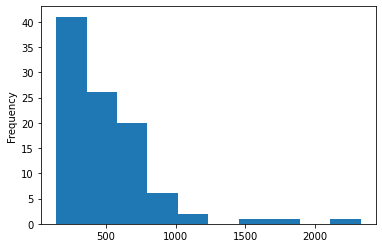

In [6]:
time_taken.plot.hist()

In [20]:
mean_std_series = pd.Series(
    [(x - time_taken.mean()) / time_taken.std() for x in time_taken.to_list()]
)
mean_std_series.loc[
    mean_std_series < mean_std_series.mean() - 3 * mean_std_series.std()
]

Series([], dtype: float64)

<AxesSubplot: >

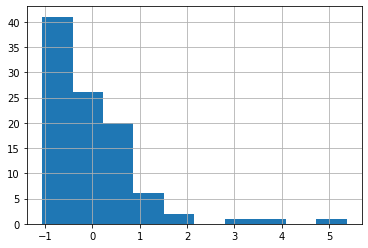

In [21]:
mean_std_series.hist()